# Preprocessing Notes

I believe there are 2 crucial components to this experiment that are **more important** than type of Neural Network:
- collection of good data with various scenarios
- preporcesing of the images to remove unnecessary training burden

## Steps 

- Crop the images
- Apply mask to leave only essential data
- Grayscale (see "Conclusions and assumptions")
- Blur the image to remove pixelation and smooth the embankments
- POSSIBLY: Detect "Canny Edges"
- POSSIBLY: Use Hugh algorithm to connect dots (draw lines)
- POSSIBLY: throw out **everything** else except left/right lanes
- Scale down the images to 28x28 if possible
- Visually verify all kinds of landscapes 
    - if I (human) can tell immediately how to steer then I can teach Neural Network to do so, too.

In [1]:
data_dir = "../../../DATA/behavioral_cloning_data/"
import csv

# TODO implement batch_from, batch_to - I did not need it for 8037 rows
# TODO implement has_header_row
def read_csv(file_path):
    # Opening spreadsheet to read in TEXT mode: 'rt'
    with open(file_path, 'rt') as csvfile:
        # Most common format of CSV, TODO improve
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='"') 
        row_counter = 0
        headers = []
        data = []
        for row in spamreader:
            row_counter = row_counter + 1
            
            if row_counter == 1:
                headers = row
                # print (type(row))
                # print ( row)
                # print ('\t '.join(row))
            elif 1 < row_counter < 3:
                # print (type(row))
                # print ( row)
                # print ('\t '.join(row))
                data.append(row)
            else:
                data.append(row)
        print("row_counter", row_counter)
        return headers, data
    
# TEST:    
headers, data = read_csv(file_path = data_dir + 'driving_log.csv')
print("headers \n",headers)
print("3rd row of data \n",data[2:3])

row_counter 8037
headers 
 ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
3rd row of data 
 [['IMG/center_2016_12_01_13_31_12_937.jpg', ' IMG/left_2016_12_01_13_31_12_937.jpg', ' IMG/right_2016_12_01_13_31_12_937.jpg', ' 0', ' 0', ' 0', ' 1.453011']]


In [2]:
def get_image_center_values(matrix):
    column_image_center = 0
    return [row[column_image_center] for row in matrix]

def get_image_left_values(matrix):
    column_image_left = 1
    return [row[column_image_left] for row in matrix]

def get_image_right_values(matrix):
    column_image_right = 2
    return [row[column_image_right] for row in matrix]

def get_steering_values(matrix):
    column_steering = 3
    return [float(row[column_steering]) for row in matrix]

def get_throttle_values(matrix):
    column_throttle = 4
    return [float(row[column_throttle]) for row in matrix]

def get_brake_values(matrix):
    column_brake = 5
    return [float(row[column_brake]) for row in matrix]

def get_speed_values(matrix):
    column_speed = 6
    return [float(row[column_speed]) for row in matrix]

#TEST:
speed_values = get_speed_values(data)
print("print ~53rd speed value", speed_values[51:53]) 

steering_values = get_steering_values(data)
print("print ~53rd steering value", steering_values[51:53]) 

print ~53rd speed value [2.124567, 3.286475]
print ~53rd steering value [0.0617599, 0.05219137]


In [3]:
import numpy as np
import random
import math
from matplotlib import pyplot as plt

def margin(value):
    return value*(5/100)

def plot_histogram(name, values, change_step):
    
    min_value = min(values)
    print("min_value", min_value)
    max_value = max(values)
    print("max_value", max_value)
    
    spread = max_value-min_value
    print("spread", spread)
    recommended_bins = math.ceil(spread/change_step)
    print("recommended number of classes", recommended_bins)
    
    bins = np.linspace(math.floor(min(values)), 
                       math.ceil(max(values)),
                       recommended_bins)

    plt.xlim([
        min_value - margin(min_value), 
        max_value + margin(max_value)])

    plt.hist(values, bins=bins, alpha=0.5)
    plt.title('Distribution of ' + name)
    plt.xlabel('values')
    plt.ylabel('occurance')

    plt.show()


# Steering value distribution

It appears, as expected that most of the driving is straight and the allowed values are from -1 to +1.

Most values are in the -0.25 to +0.25 range.

I would **err on the prudent side** and avoid the values above |0.25|.

min_value -0.9426954
max_value 1.0
spread 1.9426953999999999
recommended number of classes 39


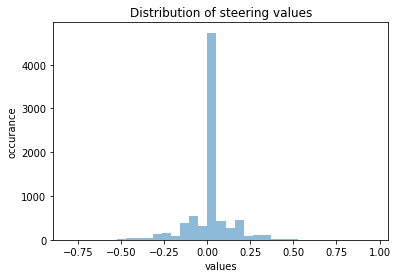

In [4]:
change_step=0.05 # test data changes
plot_histogram("steering values", steering_values, change_step)

# Speed value distribution

It appears, most of the driving is done at top speed of 30mph.

There is no sense to change speed in smaller increments than 1 mph.

min_value 0.5024896
max_value 30.70936
spread 30.2068704
recommended number of classes 31


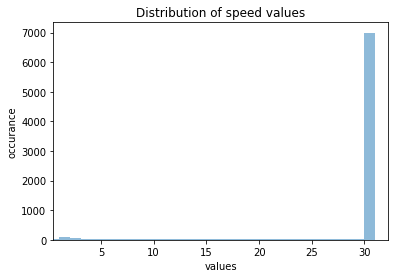

In [5]:
change_step=1 # test data changes
plot_histogram("speed values", speed_values, change_step)

# Select random data samples

In [6]:
image_center_values = get_image_center_values(data)

In [7]:
# not random, sanity check
print(speed_values[3])
print(image_center_values[3])

1.438419
IMG/center_2016_12_01_13_31_13_037.jpg


In [8]:
def crop_image(image_index):
    print("my pick #", image_index, speed_values[image_index])
    image_name = image_center_values[image_index]

    # Image read and display
    import matplotlib.image as mpimg
    from PIL import Image

    image_original = Image.open(data_dir + image_name)
    #image_original = mpimg.imread(data_dir + image_name) 

    from PIL import Image
    print(image_original.size)

    left = 0
    upper = 70
    right = 320
    lower = 140 # 160 original
    image_crop = image_original.crop((left, upper, right, lower))

    #plt.imshow(image_crop)
    #print("cropped image #", image_index, image_name )
    #plt.show()
    return image_crop

In [9]:
import cv2
def grayscale(image):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [10]:
def gaussian_blur(image, kernel_size=5): # 5 
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

In [11]:
def canny(image, low_threshold=50, high_threshold=250): # homework low_threshold=20, high_threshold=130
    """Applies the Canny transform"""
    return cv2.Canny(image, low_threshold, high_threshold)

In [12]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [13]:
def mask_vertices(image):
    """

    """
    height = image.shape[0]
    width = image.shape[1]

    top_left = (width*0.3, 0)
    top_right = (width-width*0.3, 0)
     
    mid_left_high = (0, height*0.2) 
    mid_right_high = (width, height*0.2)  
    
    mid_left_low = (0, height*0.9) 
    mid_right_low = (width, height*0.9)
    
    # on the bottom start high because of the dashboard
    bottom_center_left = (width*0.27, height*0.95) 
    bottom_center_right = (width-width*0.27, height*0.95) 
    
    # we are NOT following a center line in this code, so cut it out
    bottom_center = (width/2, height*0.55) 


    # add points clockwise
    vertices = np.array([[
        top_left, 
        top_right, 
        mid_right_high, mid_right_low,
        bottom_center_right,
        bottom_center, bottom_center_left,
        mid_left_low, 
        mid_left_high 
    ]], dtype=np.int32)
    return vertices

In [14]:
import PIL
import numpy
from PIL import Image

def resize_image(numpy_array_image, new_height):
    # convert nympy array image to PIL.Image
    image = Image.fromarray(numpy.uint8(numpy_array_image))

    #print(image.size)
    old_width = float(image.size[0])
    old_height = float(image.size[1])

    ratio = float( new_height / old_height)
    #print("ratio", ratio)

    new_width = int(old_width * ratio)
    image = image.resize((new_width, new_height), PIL.Image.ANTIALIAS)
    #img.save(‘resized_image.jpg’)
    #plt.imshow(img, cmap='gray')
    #plt.show()
    #print(img.size)

In [15]:
def preprocessing_pipline(image_index, should_plot=False):
    image_crop = array(crop_image(image_index)) 
    # convert output to numpy array
    if should_plot:
        plt.imshow(image_crop)
        plt.show()

    image_mask = region_of_interest(
        image_crop, 
        mask_vertices(image_crop))
    if should_plot:
        plt.imshow(image_mask, cmap='gray')
        plt.show()
    
    image_gray = grayscale(image_mask)
    
    if should_plot:
        plt.imshow(image_gray, cmap='gray')
        plt.show()

    image_gaussian = gaussian_blur(image_gray, kernel_size=5)
    if should_plot:
        plt.imshow(image_gaussian, cmap='gray')
        plt.show()
    
    image_canny = canny(image_gaussian, low_threshold=100, high_threshold=190)
    if should_plot:
        plt.imshow(image_canny, cmap='gray')
        plt.show()
    
    image_resized = resize_image(image_canny, new_height=28)
    return image_resized
    



my pick # 6563 30.18661
(320, 160)
cropped image # 6563 IMG/center_2016_12_01_13_44_12_451.jpg


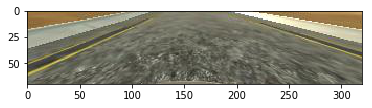

In [16]:
from numpy import array
import random
image_index = random.randrange( len(speed_values))
image = preprocessing_pipline(image_index, should_plot=False)